Run the following cell to load all the required packages...

In [1]:
library("purrr")
library("tidyverse")
library("moderndive")
library("infer")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Use `sample_n` to create one sample of 100 balls from the `bowl` data set. Make sure you are sampling **without** replacement. Call your sample `one_sample_bowl`.

In [24]:
one_sample_bowl <- bowl |> sample_n(100)
one_sample_bowl |> count(color)

color,n
<chr>,<int>
red,36
white,64


With bootstrap resampling we can calculate a confidence interval for the proportion of red balls even though we only have one sample.

To find a confidence interval,

1. use `rep_sample_n` with `replace = TRUE` to compute 1000 bootstrap replicates from your `one_sample_bowl` table. Each bootstrap should be the same size as your original sample.
2. `group_by` the replicate column, and,
3. find the proportion of red balls in each bootstrap replicate group using `summarize`.
4. Last, find the confidence interval bounds using this code snippet:

```r
summarize(
    lower_ci = quantile(prop_red, 0.025), 
    upper_ci = quantile(prop_red, 0.975)
)
```

In [36]:
one_sample_bowl |>
  rep_sample_n(size = 100, replace = TRUE, reps = 1000) |>
  group_by(replicate) |>
  summarize(prop_red = (sum(color == "red") / n())) |>
  summarize(
    lower_ci = quantile(prop_red, 0.025),
    upper_ci = quantile(prop_red, 0.975)
  )

lower_ci,upper_ci
<dbl>,<dbl>
0.26,0.45


Is the true value (i.e. the actual proportion of red balls in `bowl`) inside your confidence interval?

In [37]:
900/2400

[1] 0.375

**Let's do the same thing as above for 1,000 iterations...**

Execute the following code. This runs the *sample* plus *bootstrap resample* steps 1,000 times and captures the output in a dataframe called `bowl_ci_data`. Each row in `bowl_ci_data` holds a confidence interval created from a sample of size 100 and 1,000 bootstrap resamples.

In [30]:
bowl_samples = rep_sample_n(bowl, replace = FALSE, size = 100, reps = 1000) |>
    rename(original_sample = replicate)

bowl_ci_data = bowl_samples |> 
    group_by(original_sample) |>
    group_split() |> 
    map_dfr(
        ~rep_sample_n(.x, replace = TRUE, size = 100, reps = 1000) |>
            rename(bs_sample = replicate) |>
            group_by(original_sample, bs_sample) |>
            summarize(prop_red = sum(color == 'red') / n(), .groups = 'drop') |>
            group_by(original_sample) |>
            summarize(
                lower_ci = quantile(prop_red, 0.025), 
                upper_ci = quantile(prop_red, 0.975),
            )
    )

Use `geom_segment()` to plot 100 confidence intervals. Add a vertical line showing the position of the "true value."

**HINT:**
- you can use `sample_n` to select only 100 CIs from `bowl_ci_data`, and,
- you can use `mutate(y_pos = row_number())` to get a column to map to `y` in your chart.

**[Here is an example chart](https://raw.githubusercontent.com/UNC-DATA-730/lecture-notebooks/main/07-bootstrap-resampling/in-class-exercises/ci_plot_example.png)**

original_sample,lower_ci,upper_ci
<int>,<dbl>,<dbl>
1,0.27,0.46
2,0.31,0.50
3,0.31,0.50
4,0.35,0.54
5,0.25,0.43
6,0.35,0.54


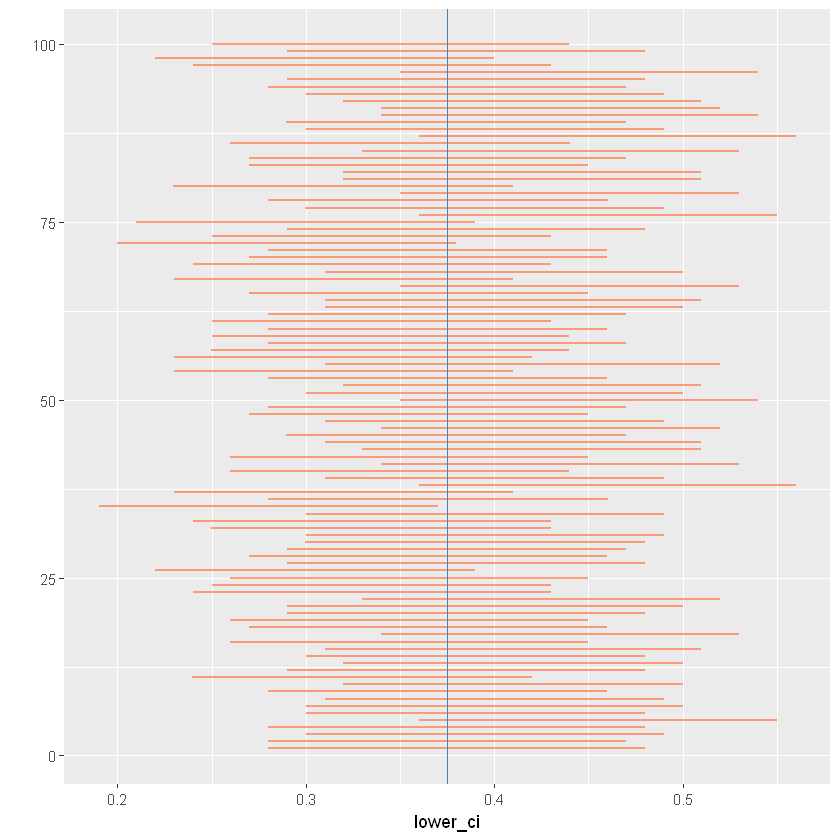

In [33]:
bowl_ci_data |> head()

bowl_ci_data |>
  sample_n(100) |>
  mutate(y_pos = row_number() ) |>
  ggplot(aes(y = y_pos, x=lower_ci, yend = y_pos, xend = upper_ci)) +
  geom_segment(linewidth = 0.8, alpha = 0.75, color = 'coral') +
  geom_vline(xintercept = 0.375, color = 'steelblue') +
  labs(y = '')


`mutate(inside_ci = lower_ci <= 0.375 & upper_ci >= 0.375)` determines if a confidence interval in `bowl_ci_data` holds the "true value." Combine this `mutate` operation with `summarize` to calculate the proportion of confidence intervals that contain the true value.

In [41]:
bowl_ci_data |> head()
bowl_ci_data |> tail()

bowl_ci_data |> mutate(inside_ci = lower_ci <= 0.375 & upper_ci >= 0.375) |>
  summarize(
    n_true_value = sum(inside_ci),
    frac_contain_true = n_true_value / n()
  )

original_sample,lower_ci,upper_ci
<int>,<dbl>,<dbl>
1,0.27,0.46
2,0.31,0.50
3,0.31,0.50
4,0.35,0.54
5,0.25,0.43
6,0.35,0.54


original_sample,lower_ci,upper_ci
<int>,<dbl>,<dbl>
995,0.25,0.43000
996,0.31,0.50025
997,0.27,0.45000
998,0.23,0.41000
999,0.19,0.38000
1000,0.26,0.46000


n_true_value,frac_contain_true
<int>,<dbl>
968,0.968


Does this value make sense? Consider that we are calculating 95% confidence intervals in this exercise...